In [1]:
!pip install cptac
!pip install --upgrade cptac

Requirement already up-to-date: cptac in c:\users\chels\anaconda3\lib\site-packages (0.8.0)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cptac
import pyensembl
from scipy import stats

In [3]:
cptac.download(dataset="luad")
luad = cptac.Luad()

cptac warning: The LUAD dataset is under publication embargo until July 01, 2020. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\chels\anaconda3\lib\site-packages\ipykernel_launcher.py, line 2)


In [4]:
ensembl = pyensembl.EnsemblRelease()

In [5]:
luad_cnv = luad.get_CNV()

In [6]:
def separate(hiCut, lowCut, data):
  """
  Counts the Number of patients with high and low value for each gene.
  """
  sepDict = dict()
  for column in data:
    numHi = 0
    numLow = 0
    numNeu = 0
    for i in data[column]:
        if i > hiCut:
            numHi += 1
        elif i < lowCut:
            numLow += 1
        else:
            numNeu += 1 
    sepDict[column] = [numHi, numNeu, numLow]
  return sepDict

In [7]:
def get_counts_and_average(data):
  """
  Takes a CNV dataframe and generates a dataframe with the counts of high, low and neutral values
  """
  df = pd.DataFrame(data = separate(.3,-.2,data), index = ["amplifications", "neutral", "deletions"])
  df = df.append(pd.DataFrame(data.mean(0), columns=['average']).transpose(), sort=True)
  return df.transpose()

In [8]:
luad_counts = get_counts_and_average(luad_cnv)

In [9]:
def add_chromo_and_loc(my_dict, cancer):
    chromo = list()
    locations = list()
    not_found = list()
    count = 0
    for gene in list(my_dict.index.get_level_values(0)):
        count += 1
        try:
            e_gene = ensembl.genes_by_name(gene)
            chromo.append(e_gene[0].contig)
            locations.append((e_gene[0].start + e_gene[0].end)/2)
        except:
            not_found.append(gene)
            chromo.append(None)
            locations.append(None)
    my_dict['chromo'] = chromo
    my_dict['location'] = locations
    my_dict['cancer'] = cancer
    print(len(not_found)/count)
    return my_dict

In [10]:
luad_counts = add_chromo_and_loc(luad_counts, "LUAD")

0.037577204546634144


In [11]:
chromosome_num = '8'

In [12]:
luad_counts_cleaned = luad_counts.dropna(subset=['location'])
luad_counts_cleaned_8 = luad_counts_cleaned[luad_counts_cleaned.chromo=='8']

In [17]:
genes_before_intersect = luad_counts_cleaned_8[luad_counts_cleaned_8.deletions > 35]

In [18]:
luad_counts_8 = luad_counts[luad_counts.chromo == chromosome_num]
luad_counts_8 = pd.melt(luad_counts_8, id_vars=['chromo', 'location', 'cancer'], value_vars=['amplifications', 'deletions'])

In [20]:
max(genes_before_intersect.location)

30794385.5

In [22]:
genes_before_intersect[genes_before_intersect.location > 30000000]

,amplifications,neutral,deletions,average,chromo,location,cancer
Name,,,,,,,
DCTN6,0.0,72.0,37.0,-0.139397,8,30169979.0,LUAD
GSR,0.0,73.0,36.0,-0.132609,8,30702956.0,LUAD
GTF2E2,0.0,72.0,37.0,-0.137172,8,30618277.0,LUAD
LEPROTL1,0.0,73.0,36.0,-0.137787,8,30136308.0,LUAD
MBOAT4,0.0,72.0,37.0,-0.139397,8,30138168.0,LUAD
PPP2CB,0.0,73.0,36.0,-0.131341,8,30794385.5,LUAD
RBPMS,0.0,71.0,38.0,-0.141797,8,30478383.5,LUAD
SARAF,0.0,73.0,36.0,-0.137787,8,30073105.5,LUAD
SMIM18,0.0,72.0,37.0,-0.137172,8,30642322.0,LUAD


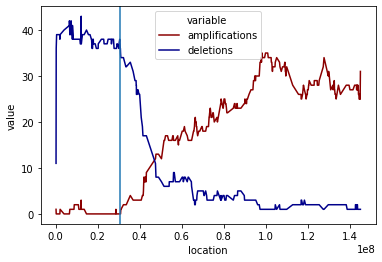

In [19]:
sns.lineplot(x="location", y="value", hue="variable", palette=['darkred', 'darkblue'], data=luad_counts_8)
plt.axvline(max(genes_before_intersect.location))